# Vibrational spectra of Si

Here we compute the infrared and Raman spectra of silicon using `aiida-vibroscopy`.


## Finite electric fields

In the Placzek approximations (good for insulators), all the needed quantities for Raman can be computed as finite difference using the electric fields.
Now we a more challenging task, as a __third order derivative__ is needed: __the Raman tensor__. This is defined as:

\begin{equation}
    \frac{\partial \chi_{ij}}{\partial \tau_{K,k}} 
    =
    \frac{1}{\Omega}
    \frac{\partial^2 F_{K,k}}{\partial \mathcal{E}_i \partial \mathcal{E}_j}
\end{equation}

The same theory we saw in previous tutorials applies here. Note that for computing _second order_ derivatives of forces we need a slightly different formula:

\begin{equation}
    \left . \frac{\partial f(x)}{\partial x} \right|_{x=0}
    =
    \frac{1}{h^2}
    \left [
        f(h) -2f(0) +f(-2h)
    \right ]
    + \mathcal(O)(h^2)
\end{equation}

Have a look at the [finite difference coefficients](https://en.wikipedia.org/wiki/Finite_difference_coefficient) for coefficients of any accuracy order.

In [1]:
from local_module import load_temp_profile

# If you download this file, you can run it with your own profile.
# Put these lines instead:
# from aiida import load_profile
# load_profile()
data = load_temp_profile(
    name="raman-tutorial",
    add_computer=True,
    add_pw_code=True,
    add_sssp=True,
)

/opt/conda/lib/python3.8/site-packages/paramiko/transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,



## The `IRamanSpectraWorkChain`

For computing the spectra we need both phonons and Raman tensors.
Let's import the WorkChain and run it! We use the `get_builder_from_protocol` to get a __prefilled__ builder with __all inputs__. 

::: {note}
These inputs should be considered __not as converged parameters__, but as a good starting point. You may also need to tweak some parameters, e.g. add magnetization etc., depending on your case. 
:::

In [2]:
from aiida.plugins import DbImporterFactory

CodDbImporter = DbImporterFactory('cod')

cod = CodDbImporter()
results = cod.query(id='1526655') # Si   1526655
structure = results[0].get_aiida_structure() # it has 8 atoms

In [3]:
from aiida.plugins import WorkflowFactory
from aiida.engine import run_get_node

IRamanSpectraWorkChain = WorkflowFactory("vibroscopy.spectra.iraman")

builder = IRamanSpectraWorkChain.get_builder_from_protocol(
    code=data.pw_code,
    structure=structure,
    protocol="fast",
)

results, calc = run_get_node(builder)

08/25/2023 09:57:41 PM <1014064> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [106|IRamanSpectraWorkChain|run_spectra]: submitting `HarmonicWorkChain` <PK=108>
08/25/2023 09:57:41 PM <1014064> aiida.engine.processes.functions: [WARNING] function `generate_preprocess_data` has invalid type hints: unsupported operand type(s) for |: 'AbstractNodeMeta' and 'NoneType'
08/25/2023 09:57:41 PM <1014064> aiida.engine.processes.functions: [WARNING] function `generate_phonopy_data` has invalid type hints: unsupported operand type(s) for |: 'AbstractNodeMeta' and 'NoneType'
08/25/2023 09:57:42 PM <1014064> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [108|HarmonicWorkChain|run_phonon]: submitting `PhononWorkChain` <PK=114>
08/25/2023 09:57:42 PM <1014064> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [108|HarmonicWorkChain|run_dielectric]: submitting `DielectricWorkChain` <PK=118>
08/25/2023 09:57:43 PM <1014064> aiida.orm.nodes.proc

These are the results:

In [4]:
results

{'output_dielectric': AttributeDict({'fields_data': AttributeDict({'field_index_2': AttributeDict({'0': <TrajectoryData: uuid: 6cdaca66-3cfb-4012-b557-65e61d348523 (pk: 246)>, '1': <TrajectoryData: uuid: 132dbb1d-ddf5-4a47-b158-9c1f07209727 (pk: 268)>}), 'field_index_3': AttributeDict({'0': <TrajectoryData: uuid: c5d3dafe-008e-4400-ba6f-762e3b15121d (pk: 250)>, '1': <TrajectoryData: uuid: 534d19a6-c13e-4d69-9086-f5a8a9988735 (pk: 272)>})}), 'tensors': AttributeDict({'numerical_accuracy_2_step_2': <ArrayData: uuid: 14d990ca-e2d7-4e03-a1cd-430ebec2bb70 (pk: 294)>, 'numerical_accuracy_2_step_1': <ArrayData: uuid: 3b4c38ee-175a-495d-bb72-d025c3e84aa9 (pk: 296)>, 'numerical_accuracy_4': <ArrayData: uuid: c4290950-7f09-4707-9dd5-8cbeffe44e72 (pk: 298)>}), 'critical_electric_field': <Float: uuid: 030bb7bd-3a2f-440f-95cd-58d6fdd023e1 (pk: 191) value: 0.00091230365735815>, 'electric_field_step': <Float: uuid: bf88df31-621a-42a6-8ba6-49fe1bb0d443 (pk: 198) value: 0.00045615182867907>, 'units': <

## The `VibrationalData`

In aiida-vibroscopy we design a data type able to store __all__ the phonon and dielectric properties, to ease the share of the data and make it as costistent as possible.

In this data, you can access to multiple information:

- Structure (cell, sites, ...)
- Symmetry
- Dielectric tensor ($\epsilon^{\infty}$)
- Born effective charges ($Z^*$)
- Raman tensors ($\partial \chi / \partial \tau$)
- Non-linear optical susceptibility ($\chi^{(2)}$)

Again, Born effective charges and non-linear optical susceptibility are null in silicon, due to symmetry. In the next tutorial we will compute these quantities for AlAs, which has non vanishing tensors.

In [5]:
vibro = calc.outputs.vibrational_data.numerical_accuracy_4
print("The VibrationalData: ", vibro, "\n")
print("The dielectric tensor: ", "\n", vibro.dielectric.round(5), "\n")
print("The Raman tensors (in 1/Angstrom): ", "\n", vibro.raman_tensors.round(5), "\n")

The VibrationalData:  uuid: 07be12d7-d563-4e75-a286-1f1a64b6f02d (pk: 310) 

The dielectric tensor:  
 [[11.08481 -0.      -0.     ]
 [ 0.      11.08481  0.     ]
 [ 0.      -0.      11.08481]] 

The Raman tensors (in 1/Angstrom):  
 [[[[-0.      -0.      -0.     ]
   [-0.      -0.      -0.08896]
   [-0.      -0.08896 -0.     ]]

  [[ 0.      -0.      -0.08896]
   [ 0.      -0.      -0.     ]
   [-0.08896 -0.      -0.     ]]

  [[-0.      -0.08896 -0.     ]
   [-0.08896 -0.      -0.     ]
   [-0.      -0.      -0.     ]]]


 [[[ 0.      -0.       0.     ]
   [ 0.      -0.       0.08896]
   [ 0.       0.08896  0.     ]]

  [[ 0.      -0.       0.08896]
   [-0.      -0.      -0.     ]
   [ 0.08896 -0.       0.     ]]

  [[ 0.       0.08896  0.     ]
   [ 0.08896  0.       0.     ]
   [ 0.       0.       0.     ]]]] 



And we can also check how much the Raman tensors, which are third order derivatives, are sensible to the numerical accuracy chosen. Usually, the Raman tensor is expressed in Å$^2$. To get it, one can use the convention in the code:

\begin{equation}
    \left [
        \frac{\partial \chi}{\partial \tau}
    \right] (\text{Å}^2)
    = 
    \Omega_{unitcell}
    \left [
        \frac{\partial \chi}{\partial \tau}
    \right] (\text{Å}^{-1})
\end{equation}

In [6]:
vol = calc.outputs.vibrational_data.numerical_accuracy_4.get_unitcell().get_cell_volume()

print(
    calc.outputs.vibrational_data.numerical_accuracy_4.raman_tensors[1,0,1,2]*vol,
    calc.outputs.vibrational_data.numerical_accuracy_2_step_1.raman_tensors[1,0,1,2]*vol,
    calc.outputs.vibrational_data.numerical_accuracy_2_step_2.raman_tensors[1,0,1,2]*vol,
)

13.860430602407677 13.89715997246768 14.007348082647715


We can see that the values are converged within 0.1 Å$^2$ with all three steps.

## Plotting the powder Raman spectra

Now, we can get directly from the data the Raman intensities.

In [7]:
hh_intensities, hv_intensities, frequencies, labels = vibro.run_powder_raman_intensities(
    frequency_laser=532, temperature=300)
print(frequencies, "\n", labels)

[531.91425155 531.91425155 531.91425155] 
 ['T2g', 'T2g', 'T2g']


We have 3 degenerate modes. Quite expected for silicon, which is very symmetric. To plot the actual spectra:

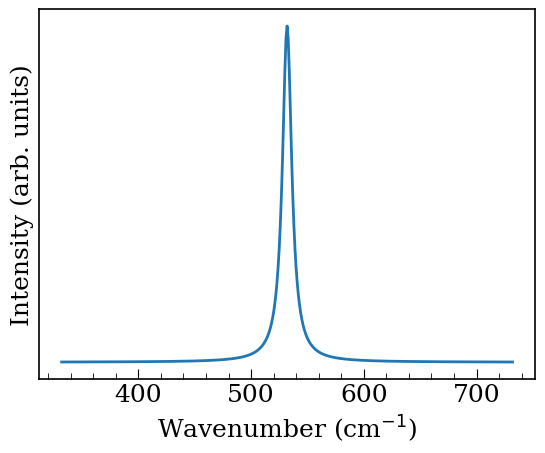

In [8]:
from aiida_vibroscopy.utils.plotting import get_spectra_plot

total_intensities =  hh_intensities + hv_intensities
plt = get_spectra_plot(frequencies, total_intensities)
plt.show()

## Analysing the workflow

Look how the complexity of computing a Raman spectra has been handled __fully automatically__.

In [9]:
%verdi process status {calc.pk}

IRamanSpectraWorkChain<106> Finished [0] [2:if_(should_run_average)]
    └── HarmonicWorkChain<108> Finished [0] [4:if_(should_run_phonopy)]
        ├── generate_preprocess_data<109> Finished [0]
        ├── PhononWorkChain<114> Finished [0] [7:if_(should_run_phonopy)]
        │   ├── generate_preprocess_data<119> Finished [0]
        │   ├── get_supercell<132> Finished [0]
        │   ├── create_kpoints_from_distance<137> Finished [0]
        │   ├── PwBaseWorkChain<140> Finished [0] [3:results]
        │   │   ├── PwCalculation<143> Finished [0]
        │   │   └── PwCalculation<160> Finished [0]
        │   ├── get_supercells_with_displacements<170> Finished [0]
        │   ├── PwBaseWorkChain<176> Finished [0] [3:results]
        │   │   ├── PwCalculation<182> Finished [0]
        │   │   └── PwCalculation<211> Finished [0]
        │   └── generate_phonopy_data<220> Finished [0]
        ├── DielectricWorkChain<118> Finished [0] [11:results]
        │   ├── create_kpoints_from_dista

## Convergence with k points

As a final remark, we show here how the convergence with k points is speeded up by sampling in this _directional_ manner, compared to the most 'traditional' uniform mesh. 

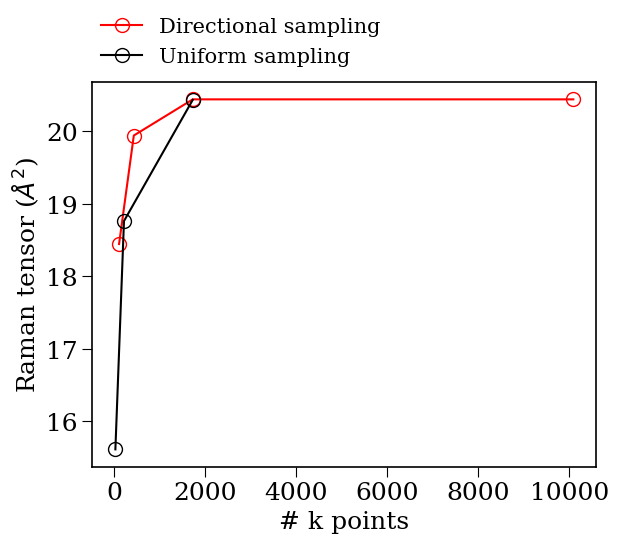

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Some options to make the plot nice
plt.rcParams['font.size'] = 18
plt.rcParams['font.family'] = "serif"
plt.rcParams['text.usetex'] = False
plt.rcParams['xtick.major.size'] = 7.0
plt.rcParams['xtick.minor.size'] = 4.
plt.rcParams['ytick.major.size'] = 7.0
plt.rcParams['ytick.minor.size'] = 4.
plt.rcParams['axes.linewidth'] = 1.2
plt.rcParams['legend.fontsize'] = 15

# Directional sampling
raman_new = np.array([18.445, 19.943, 20.442, 20.442])
kpoints_new = np.array([3*6*6, 3*12*12, 3*24*24, 3*58*58])

# Uniform sampling
raman = np.array([15.610, 18.762, 20.436])
kpoints = np.array([3*3*3, 6*6*6, 12*12*12])

# Plotting
fig, ax = plt.subplots(figsize=(6.5,5)) # dichiaro il canvas e i subplots    

ax.plot(kpoints_new, raman_new, color='red', marker='o', fillstyle='none', ms=10, linewidth=1.5, linestyle='-', label='Directional sampling')  
ax.plot(kpoints, raman, color='black', marker='o', fillstyle='none', ms=10, linewidth=1.5, linestyle='-', label='Uniform sampling')  
ax.set_xlabel('# k points')  
ax.set_ylabel(r'Raman tensor ($\AA^2$)')
ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=1, mode="expand", borderaxespad=0., frameon=False)